In [ ]:
!pip install -U scikit-learn

In [3]:
import os
from os import path,listdir
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.inspection import PartialDependenceDisplay,partial_dependence

import requests
import pickle
import json

pd.options.display.max_columns = 500
import warnings
warnings.filterwarnings("ignore")

map_all = {'staphylococci':'$\it{Staphylococcus}$ spp.',
         'enterobacterales':'Enterobacterales',
         'enteros':'Enterobacterales',
         'fungi':'Fungi',
          'enterococci':'$\it{Enterococcus}$ spp.',
          'streptococci':'$\it{Streptococcus}$ spp.',
          'gram.neg':'Other Gram-negative bacteria',
          'anaerobic':'Anaerobic bacteria',
           'age':'Age',
           'duree':'Duration of surgery',
           'bmi':'BMI [kg/m²]',
           'surg':'Type of surgery',
           'asa':'ASA score',
           'class':'Wound contamination',
           'clindamycine':'Clindamycine',
           'cephalosporin.all':'Cephalosporine',
           'glycopeptide':'Glycopeptide',
           'quinolone':'Quinolone',
           'elective':'Elective procedure',
           'endo_2L':'Minimally invasive procedure',
           'nitroimidazole':'Nitroimidazole',
           'penicillin.all':'Penicilin',
           'carbapenem':'Carbapenem',
           'SAP.b':'SAP administered (yes / no)',
           'hosp_size':'Hospital size',
           'sex':'Sex',
           'other.SAP2':'Other SAP',
           'prev.hosp.b':'Hospitalization prior to surgery'}

def plot_pdp(dd,estimators,_X = 'ft_age',_Y = 'ft_bmi',title='',pdf=None):
    _X2,_Y2 = [map_all.get(x.replace('ft_',''),x.replace('ft_','').title()) for x in (_X,_Y)]
    _X2,_Y2 = [x+' (norm)' if (x.startswith('Age') or 
                               x.startswith('BMI') or 
                               x.startswith('Dur')) else x for x in (_X2,_Y2)]
    fig,axs = plt.subplots(figsize=(18.5,4),ncols=4)
    for idx,(name,E) in enumerate(estimators.items()):    
        ax = axs[idx]
        display = PartialDependenceDisplay.from_estimator(E, dd, [(_X, _Y)])
        display.plot(ax=ax, contour_kw={'cmap':'viridis'})
        display.axes_[0,0].set_xlabel(_X2)
        display.axes_[0,0].set_ylabel(_Y2)
        display.axes_[0,0].set_title(name)
    fig.suptitle(title,y=1.05)
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()  
    
url_group = 'https://raw.githubusercontent.com/HugoGuillen/microbialcomposition/main/clf_group.model'
url_label = 'https://raw.githubusercontent.com/HugoGuillen/microbialcomposition/main/clf_label.model'
url_prep = 'https://raw.githubusercontent.com/HugoGuillen/microbialcomposition/main/preprocessor.pickle'
url_input = 'https://raw.githubusercontent.com/HugoGuillen/microbialcomposition/main/template.csv'
url_labels = 'https://raw.githubusercontent.com/HugoGuillen/microbialcomposition/main/labels.json'
modelfile_group = 'model.group'
modelfile_label = 'model.label'
modelfile_prep = 'model.preprocessor'
modelinput = 'input.csv'
modellabels = 'labels.json'

# 1 - Download data from repository

In [20]:
response = requests.get(url_group)
with open(modelfile_group, 'wb') as file:
    file.write(response.content)
print('#Downloaded',modelfile_group)

response = requests.get(url_label)
with open(modelfile_label, 'wb') as file:
    file.write(response.content)
print('#Downloaded',modelfile_label)

response = requests.get(url_prep)
with open(modelfile_prep, 'wb') as file:
    file.write(response.content)
print('#Downloaded',modelfile_prep)

response = requests.get(url_input)
with open(modelinput, 'wb') as file:
    file.write(response.content)
print('#Downloaded',modelinput)

response = requests.get(url_labels)
with open(modellabels, 'wb') as file:
    file.write(response.content)
print('#Downloaded',modellabels)

#Downloaded model.group
#Downloaded model.label
#Downloaded model.preprocessor
#Downloaded input.csv
#Downloaded labels.json


# 2 - Load variables

In [94]:
with open(modelfile_prep,'rb') as f:
    preprocessor = pickle.load(f)
with open(modelfile_group,'rb') as f:
    clf_group = pickle.load(f)
with open(modelfile_label,'rb') as f:
    clf_label = pickle.load(f)
with open(modellabels,'rb') as f:
    labels = json.load(f)
    
### Get estimators
estimators = { map_all.get(col_name.replace('GROUP_',''),col_name.replace('GROUP_','').title()) : estimator 
                           for col_name, estimator in zip(labels['groups'], clf_group.estimators_)}

# 3 - Predict input data and plot

<font color="red">Download the file `input.csv` and fill with your own patient data.</font>

Predicted bacterial groups: GROUP_enterococci
Predicted bacteria: LABEL_enterococci


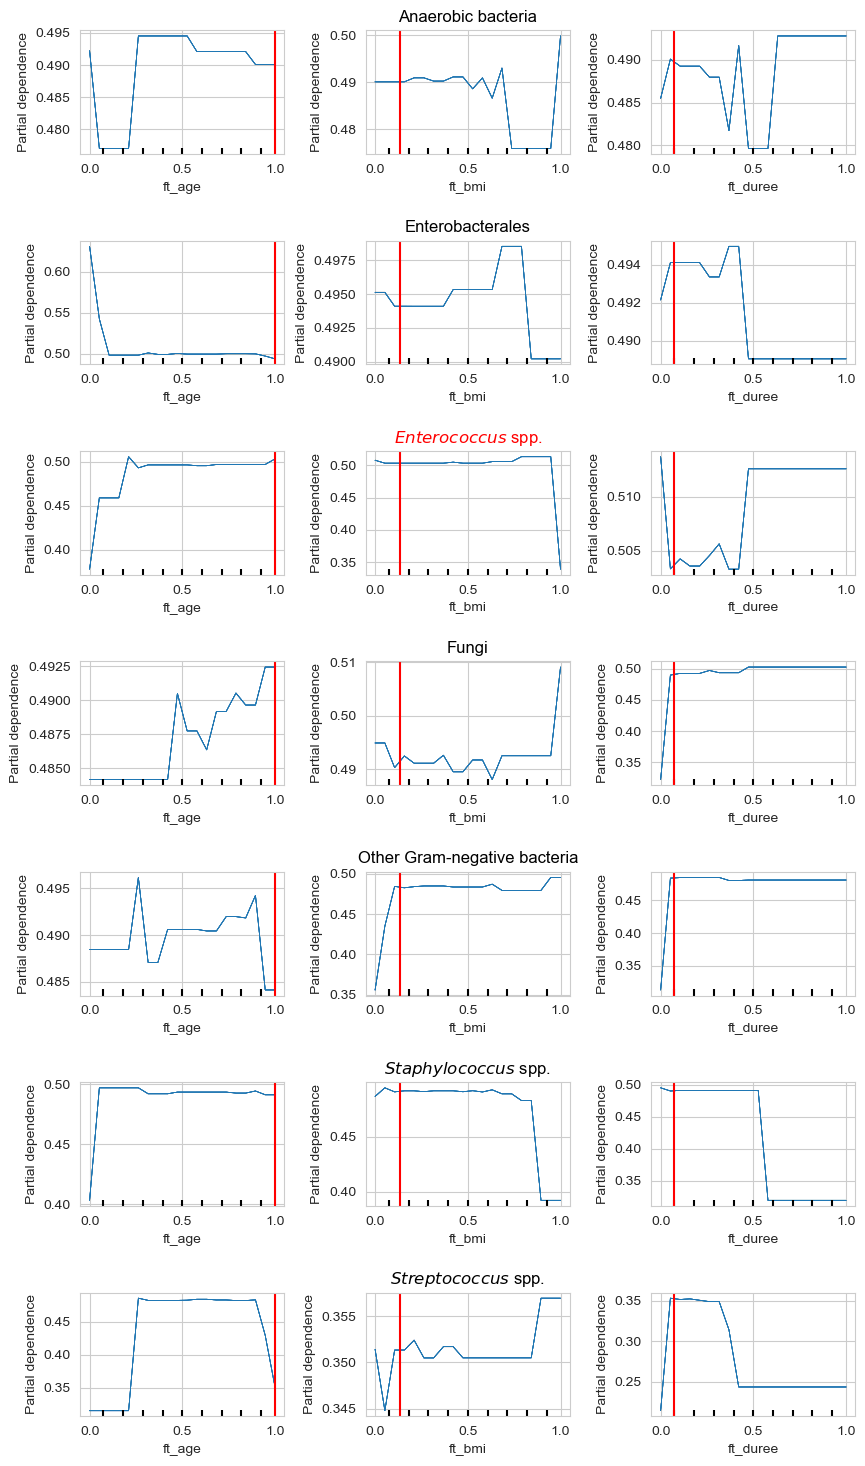

In [106]:
df = pd.read_csv(modelinput)
### Normalize
columns_prep = ['ft_age','ft_bmi','ft_duree']
df[columns_prep] = preprocessor.transform(df)
for c in columns_prep:
    df[c] = df[c].apply(lambda x:1 if x>1 else 0 if x<0 else x)

### Predict
dl = pd.DataFrame(clf_label.predict(df))
dl.columns = labels['labels']
dg = pd.DataFrame(clf_group.predict(df))
dg.columns = labels['groups']

z1 = dg.T.reset_index()
z1 = list(z1[z1[0]==1]['index'])
print('Predicted bacterial groups:',', '.join(z1))
z2 = dl.T.reset_index()
z2 = list(z2[z2[0]==1]['index'])
print('Predicted bacteria:',', '.join(z2))


sns.set_style('whitegrid')
N = 20
fig,axs = plt.subplots(figsize=(10,18),ncols=3,nrows=len(estimators))
# axs = axs.flatten()
for row,(k,v) in enumerate(estimators.items()):
    for idx,c in enumerate(['ft_age','ft_bmi','ft_duree']):
        dt = pd.concat([df] * N, ignore_index=True)
        dt[c] = np.linspace(0,1,N)    
        ax = axs[row,idx]
        display = PartialDependenceDisplay.from_estimator(v, dt, [c],kind='individual',ax=ax)    
        ax2 = display.axes_[0][0]    
        ax2.axvline(x=df[c].iloc[0],color='red')
        if idx==1:
            color = 'red' if dg.iloc[0,row]==1 else 'black'
            ax.set_title(k,color=color)
plt.subplots_adjust(wspace=0.4,hspace=0.7)
plt.savefig('ICE.pdf',bbox_inches='tight', pad_inches=.1)
plt.show()